# CAB320 Assignment 2 - Transfer Learning
Anthony Vanderkop, Thierry Peynot, Frederic Maire (Jupyter Notebook template: 2025)


## Instructions:
The functions and classes defined in this module will be called by the marker without modification. 
You should complete the functions and classes according to their specified interfaces.

No partial marks will be awarded for functions that do not meet the specifications of the interfaces.


In [1]:
### LIBRARY IMPORTS ###
import os
import numpy as np
import keras
import keras.applications as ka
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

2025-05-31 04:24:11.215366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748665451.229018      82 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748665451.232859      82 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Task 1
Implement the my_team()function 

In [2]:
def my_team():
    """
    Return the list of the team members of this assignment submission as a list
    of triplet of the form (student_number, first_name, last_name)

    """
    return [ (11032553, 'Hunter', 'Wilde'), (12026395, 'Oliver', 'Kele') ]

In [3]:
my_team()

[(11032553, 'Hunter', 'Wilde'), (12026395, 'Oliver', 'Kele')]

## Task 2
Download the small_flower_dataset from Canvas and load the data

In [4]:
# Global variable to store class name to index mapping
class_to_idx = {}

def load_data(path):
    """
    Load in the dataset from its home path. Path should be a string of the path
    to the home directory the dataset is found in. Should return numpy arrays
    with paired images and class labels.

    This function:
    1. Loads images from the small_flower_dataset directory structure
        - The dataset is organized with class folders, where folder name = class name
    2. Organizes them into features (X) and labels (Y)
    3. Returns tuple of (X, Y) where:
       - X is a numpy array of images with shape (n_samples, height, width, channels)
       - Y is a numpy array of integer labels with shape (n_samples,)
    """

    X = []
    Y = []

    # Get the global variable class_to_idx
    global class_to_idx

    # Get all subdirectories (class folders) in the path
    class_dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

    # Clear the existing dictionary and assign new integer indices to each class
    class_to_idx.clear()
    for idx, class_name in enumerate(sorted(class_dirs)):
        class_to_idx[class_name] = idx

    # Set target size for MobileNetV2 and to account for different image sizes in dataset
    target_size = (224, 224)

    # Process each class directory
    for class_name in class_dirs:
        class_path = os.path.join(path, class_name)
        class_idx = class_to_idx[class_name]

        # Get all image files in the class directory
        image_files = os.listdir(class_path)

        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)

            # Load image and convert to array with target size of 224x224 (MobileNetV2 input size)
            img = keras.utils.load_img(img_path, target_size=target_size)
            img_array = keras.utils.img_to_array(img)

            # Add to dataset
            X.append(img_array)
            Y.append(class_idx)

    # Convert lists to numpy arrays
    X = np.array(X)
    Y = np.array(Y)

    # Printf statements to check the dataset has been loaded correctly 
    print(f"Dataset loaded: {X.shape[0]} images, {len(class_to_idx)} classes")
    print(f"Image shape: {X.shape[1:]}")
    print(f"Classes: {class_to_idx}")

    return X, Y

In [5]:
X, Y = load_data("./small_flower_dataset")

Dataset loaded: 1000 images, 5 classes
Image shape: (224, 224, 3)
Classes: {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


## Task 3
Prepare your training, validation and test sets for the non-accelerated version of transfer learning.

In [6]:
def split_data(X, Y, train_fraction, randomize=False, eval_set=True):
    """
    Split the data into training and testing sets. If eval_set is True, also create
    an evaluation dataset. There should be two outputs if eval_set is False, or
    three outputs (train, test, eval) if eval_set is True.

    This function performs stratified splitting to maintain class balance, ensuring
    each split contains the same proportion of samples from each class.

    Parameters:
    -----------
    X : numpy.array
        Array of image data with shape (n_samples, height, width, channels)
    Y : numpy.array
        Array of class labels with shape (n_samples)
    train_fraction : float
        Fraction of data to use for training (between 0 and 1)
    randomize : bool, optional
        Whether to randomize the data before splitting (default: False)
    eval_set : bool, optional
        Whether to create a separate evaluation/validation set (default: True)

    Returns:
    --------
    If eval_set=True:
        (train_set, eval_set, test_set) : tuple of tuples
            Each inner tuple contains (images, labels) for the respective set
    If eval_set=False:
        (train_set, test_set) : tuple of tuples
            Each inner tuple contains (images, labels) for the respective set
    """
    # Get classes (known to be unique, but uses .unique() to catch any bugs/errors from earlier functions)
    unique_classes = np.unique(Y)

    # Lists to store indices for each split
    train_indices = []
    eval_indices = []
    test_indices = []

    # For each class, split its indices to maintain class balance
    for class_idx in unique_classes:
        # Get indices of samples belonging to this class
        class_indices = np.flatnonzero(Y == class_idx)
        num_samples = len(class_indices)

        # Randomize if requested
        if randomize:
            np.random.shuffle(class_indices)

        # Calculate split points
        train_end = int(num_samples * train_fraction)

        if eval_set:
            # Ensure equal sizes for validation and test sets
            remaining = num_samples - train_end
            val_samples = remaining // 2

            eval_end = train_end + val_samples

            # Add indices to respective sets
            train_indices.extend(class_indices[:train_end].tolist())
            eval_indices.extend(class_indices[train_end:eval_end].tolist())
            test_indices.extend(class_indices[eval_end:].tolist())
        else:
            # No eval set, just train and test
            train_indices.extend(class_indices[:train_end].tolist())
            test_indices.extend(class_indices[train_end:].tolist())

    # Convert lists to integer numpy arrays explicitly
    train_indices = np.array(train_indices, dtype=int)
    test_indices = np.array(test_indices, dtype=int)

    # Create the final datasets
    train_set = (X[train_indices], Y[train_indices])
    test_set = (X[test_indices], Y[test_indices])

    if eval_set:
        eval_indices = np.array(eval_indices, dtype=int)
        eval_set_data = (X[eval_indices], Y[eval_indices])

        # Print statement for debugging/check
        print(f"Split complete: {len(train_indices)} train, {len(eval_indices)} validation, {len(test_indices)} test images")
        return train_set, eval_set_data, test_set
    else:
        # Print statement for debugging/check
        print(f"Split complete: {len(train_indices)} train, {len(test_indices)} test images")
        return train_set, test_set

In [7]:
train_set, eval_set, test_set = split_data(X, Y, train_fraction = 0.8)

Split complete: 800 train, 100 validation, 100 test images


Report: Include details of how you have split the data to perform this training. Ensure the split is reasonable and does not introduce class imbalance during training

The array of class labels `Y` is first passed through a function which extracts only unique entries to ensure there are no repeated classes; the filtered class array `unique_classes` is then iterated over as each entry in `Y` is assigned to a unique class, resulting in a local instance of `class_indices` for each unique class, which contains all entries of that class (should be 1, excepting anomalies). The set of classes is split between the arrays `train_set` & `test_set` according to the ratio assigned to `train_fraction`.

## Task 4
Using the tf.keras.applications module download a pretrained MobileNetV2 network. 

In [8]:
def load_model():
    """
    Load in a pretrained MobileNetV2 model using the keras.applications module.

    This function:
    1. Downloads a pretrained MobileNetV2 network with weights from ImageNet
    2. Sets up the model with the input shape appropriate for our dataset (224, 224, 3)
    3. Ensures the base model layers are not trainable (frozen) for transfer learning

    Returns:
    --------
    model : keras.Model
        A pretrained MobileNetV2 model with frozen base layers, ready for transfer learning
    """

    # Load the pretrained model without the top classification layer
    # Include weights from ImageNet, and use input shape of 224x224x3
    base_model = ka.MobileNetV2(weights='imagenet', 
                            include_top=False, 
                            input_shape=(224, 224, 3))

    # Freeze the layers in the base model so they won't be trained
    for layer in base_model.layers:
        layer.trainable = False

    # Print f statements to ensure model loaded correctly
    print(f"MobileNetV2 model loaded with {len(base_model.layers)} layers")
    print(f"Input shape: {base_model.input_shape}")
    print(f"Output shape: {base_model.output_shape}")

    return base_model

In [9]:
model = load_model()

2025-05-31 04:24:39.525143: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


MobileNetV2 model loaded with 154 layers
Input shape: (None, 224, 224, 3)
Output shape: (None, 7, 7, 1280)


## Task 5
Replace the last layer of the downloaded neural network with a Dense layer of the appropriate shape for the 5 classes of the small flower dataset {(x1,t1), (x2,t2),..., (xm,tm)}.

## Task 6
Compile and train your model with an SGD optimizer using the following parameters learning_rate=0.01, momentum=0.0, nesterov=False. (NB: The SGD class description can be found at https://keras.io/api/optimizers/sgd/  )

In [10]:
def transfer_learning(train_set, eval_set, model, parameters=(0.01, 0.0, False)):
    """
    Implement and perform standard transfer learning here.

    Inputs:
        - train_set: list or tuple of the training images and labels in the
            form (images, labels) for training the classifier
        - eval_set: list or tuple of the images and labels used in evaluating
            the model during training, in the form (images, labels)
        - model: an instance of tf.keras.applications.MobileNetV2
        - parameters: tuple of parameters to use during training:
            (learning_rate, momentum, nesterov)

    Outputs:
        - model : an instance of tf.keras.applications.MobileNetV2

    """

    # Unpack parameters
    learning_rate, momentum, nesterov = parameters

    # Unpack datasets
    x_train, y_train = train_set
    x_eval, y_eval = eval_set

    # Get number of classes from the dataset
    num_classes = len(np.unique(y_train))

    # Add a global average pooling layer and a new classification layer
    x = model.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    predictions = keras.layers.Dense(num_classes, 'softmax')(x)

    # Create the final model
    final_model = keras.models.Model(model.input, predictions)

    # Compile the model with specified parameters
    optimizer = keras.optimizers.SGD(learning_rate, momentum, nesterov)
    final_model.compile(
        optimizer,
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )

    # Define callbacks for training
    checkpoint = keras.callbacks.ModelCheckpoint(
        "best_model.keras",
        monitor = 'val_accuracy',
        save_best_only = True,
        mode = 'max',
        verbose = 1
    )

    early_stopping = keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 10,  # Number of epochs with no improvement after which to stop
        restore_best_weights = True,
        verbose = 1
    )

    # Train the model
    history = final_model.fit(
        x_train, y_train,
        validation_data = (x_eval, y_eval),
        epochs = 50,  
        batch_size = 32,  
        callbacks = [checkpoint, early_stopping],
        verbose = 1
    )

    # Store the training history as an attribute for later analysis
    final_model.history = history

    return final_model

In [11]:
model_trained = transfer_learning(train_set, eval_set, model)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.2075 - loss: 1.8503
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 188ms/step - accuracy: 0.2090 - loss: 1.8472 - val_accuracy: 0.2500 - val_loss: 1.7266
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.3270 - loss: 1.5837
Epoch 2: val_accuracy improved from 0.25000 to 0.32000, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.3281 - loss: 1.5819 - val_accuracy: 0.3200 - val_loss: 1.6347
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.3888 - loss: 1.5143
Epoch 3: val_accuracy improved from 0.32000 to 0.40000, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.3906 - loss: 1.5110 - val_accuracy: 0.4000 - val_loss: 1.5048
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.4485 - loss: 1.3400
Epoch 4: val_accuracy did not improve fro

Report: Provide an overview of the function and how it works.

After first unpacking all necessary data from the input parameters, two new layers (a GAP layer & a softmax classification layer) are added to the model, which are derived from the output of the model's previous version. The new model is compiled, reusing the input parameters given for the previous model. Checkpoints & early stopping points are defined for time-saving during training. Finally, the previous version of the model is appended to the model history.

## Task 7
Plot the training and validation errors and accuracies of standard transfer 

In [12]:
def plot_errors(model):
    """
    Plot the training & validation errors & accuracies from the model's training history.

    This function:
    1. Creates two subplots: one for error & one for accuracy.
    2. Plots both training & validation metrics on each subplot.
    3. Adds appropriate labels, titles, & legend.
    """
    # Unpack the model history & epochs
    history = model.history.history
    epochs = model.history.epoch

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation error
    ax1.plot(epochs, history['loss'], 'b-', label='Training Loss')
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot training & validation accuracies
    ax2.plot(epochs, history['accuracy'], 'b-', label='Training Accuracy')
    ax2.plot(epochs, history['val_accuracy'], 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

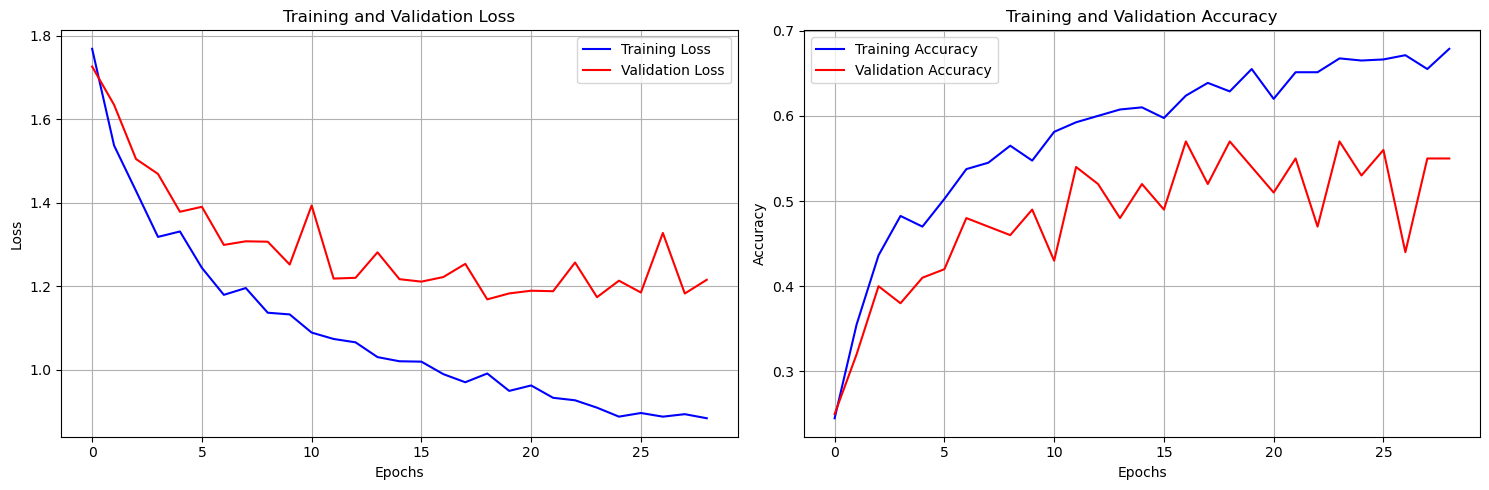

In [13]:
plot_errors(model_trained)

The training loss decreases overtime, however the validation loss plateaus and becomes noisy - suggesting overfitting. The training accuracy increases, while the validation accuracy plateaus and becomes noisy, again indicating potential overfitting of the model.

## Task 8
Experiment with 3 different orders of magnitude for the learning rate. Plot the results and discuss in the below markdown cell

In [15]:
model_slowest = transfer_learning(train_set, eval_set, model, (0.00001, 0.0, False))# 1/1000x the base learning rate
model_slower = transfer_learning(train_set, eval_set, model, (0.001, 0.0, False))   # 1/10x the base learning rate
model_faster = transfer_learning(train_set, eval_set, model, (10.0, 0.0, False))    # 1000x the base learning rate

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.1627 - loss: 1.8745
Epoch 1: val_accuracy improved from -inf to 0.24000, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - accuracy: 0.1628 - loss: 1.8736 - val_accuracy: 0.2400 - val_loss: 1.8182
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.1682 - loss: 1.8347
Epoch 2: val_accuracy did not improve from 0.24000
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.1681 - loss: 1.8353 - val_accuracy: 0.2400 - val_loss: 1.8165
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.1627 - loss: 1.8558
Epoch 3: val_accuracy did not improve from 0.24000
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.1628 - loss: 1.8555 - val_accuracy: 0.2300 - val_loss: 1.8148
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.1618 - loss: 1.8473
Epoch 4: val_accuracy did not improve from 0.24000
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.1618 - loss

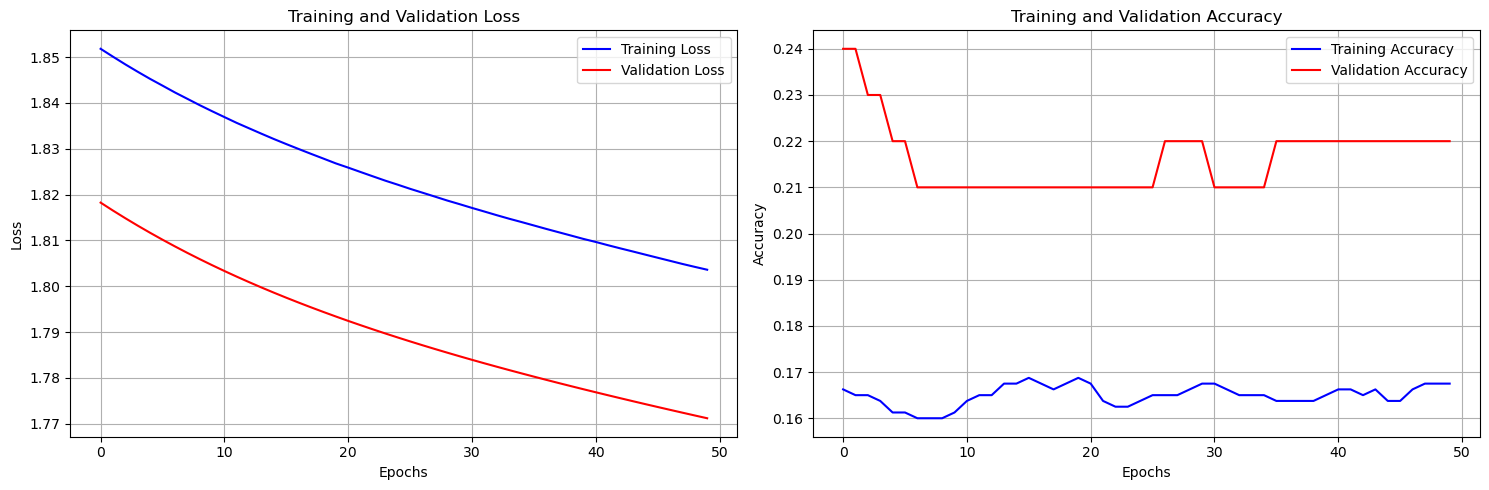

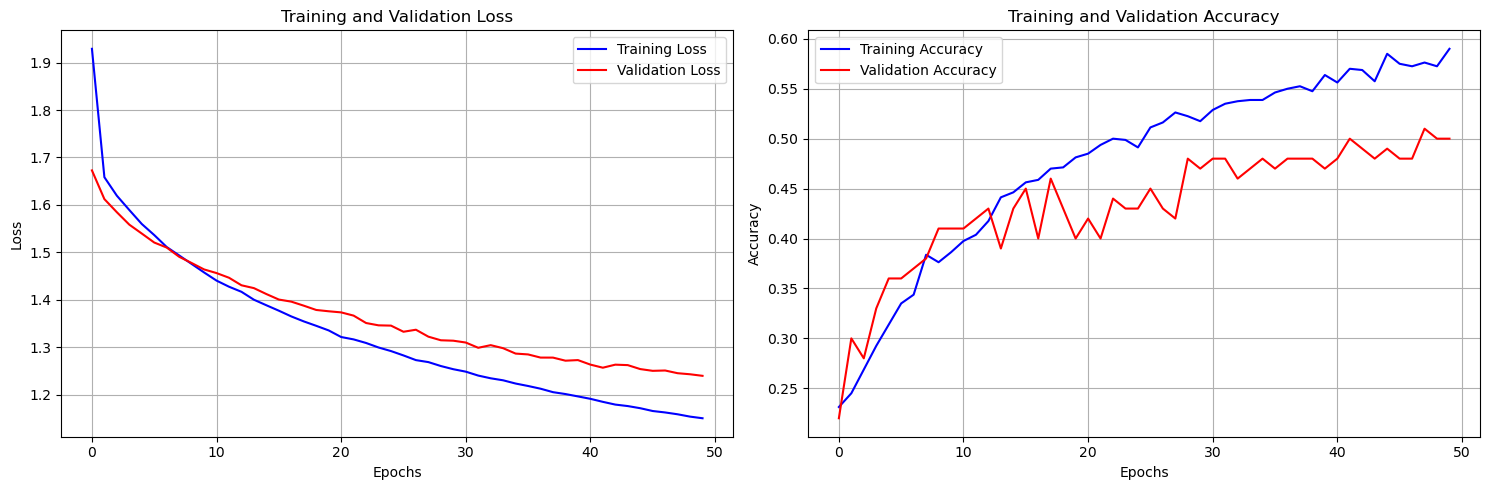

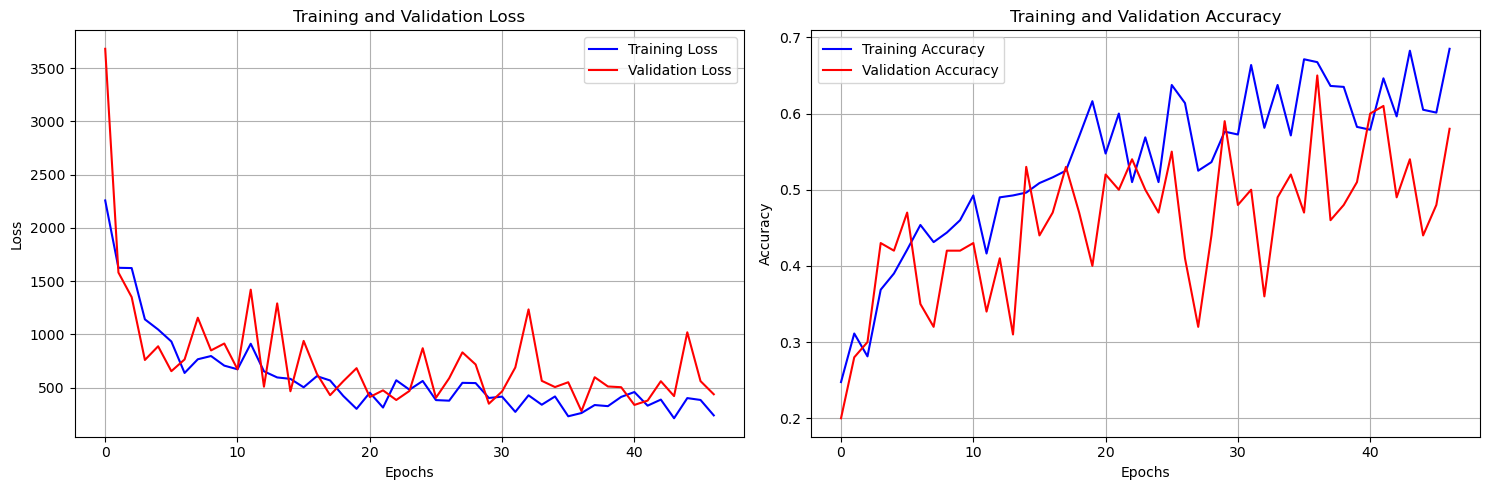

In [16]:
# Plotting the results
plot_errors(model_slowest)
plot_errors(model_slower)
plot_errors(model_faster)

### Task 8 Analysis and discussion


In the slowest model with a learning rate of 0.00001, the training and validation loss & accuracy do not change signficantly and do not converge. This indicates the learning rate is too low and no meaningful learning is occuring.

In the slower model with a learning rate of 0.001, the training and validation loss decrease consistently and converge. The training and validation accuracy increase steadily but slightly diverge and the end. This learning rate performed the best with no signs of overfitting and meaningful learning.

In the faster mode with a learning rate of 10, the training and validation loss become erratic and has a significantly higher loss value than the other models. The training and validation accuracy are also highly erratic. This indicates the learning rate is too high for the model to converge reliably.

These plots indicate a learning rate of 0.001 (1/10 of the base learning rate) performs the best for transfer learning with this dataset.

## Task 9
Run the resulting classifier on your test dataset using results from the best learning rate you experimented with. Compute and display the confusion matrix.

In [17]:
def plot_confusion(model):
    """
    Compute and display the confusion matrix for the model on the test dataset.

    This function:
    1. Gets predictions from the model on the test dataset
    2. Computes the confusion matrix comparing predictions to actual labels
    3. Visualizes the confusion matrix with appropriate labels and formatting

    Parameters:
    -----------
    model : keras.Model
        The trained model to evaluate
    """
    # Unpack the test data
    x_test, y_test = test_set

    # Get predictions from the model
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)

    # Get class names from the global class_to_idx dictionary
    class_names = list(class_to_idx.keys())

    # Create a figure
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the confusion matrix using matplotlib
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

    # Add colorbar
    ax.figure.colorbar(im, ax=ax)

    # Set ticks and labels
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names,
           yticklabels=class_names,
           xlabel='Predicted',
           ylabel='True',
           title='Confusion Matrix')

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.tight_layout()
    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step


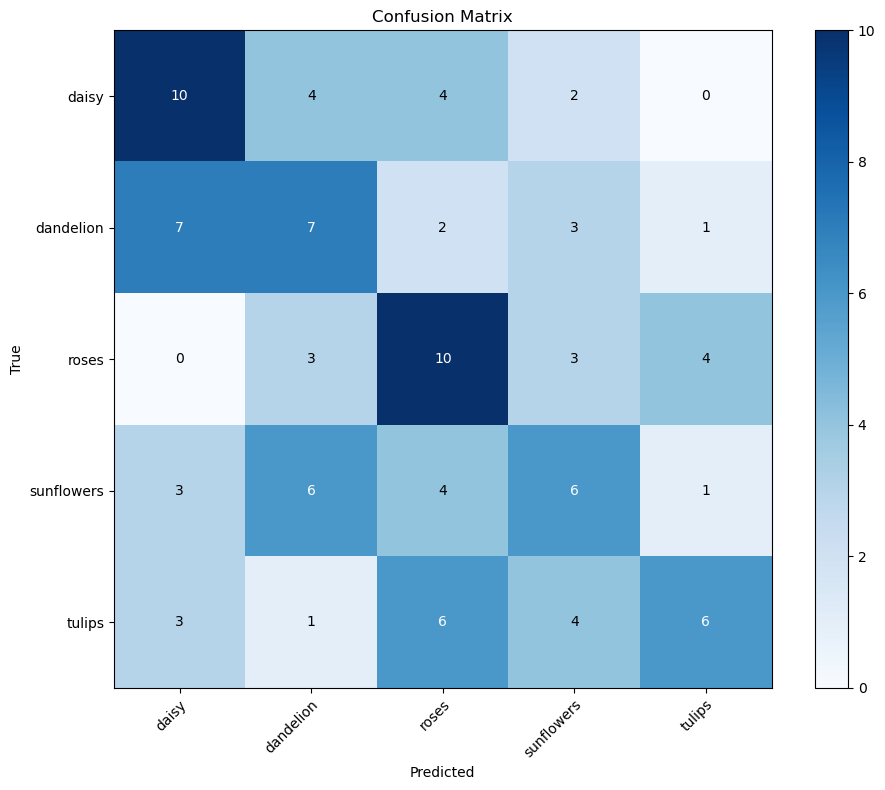

In [21]:
model_best = model_slower # The slower model exhibits the best results, with less signs of overfitting than the base model
plot_confusion(model_best)

## Task 10
Compute the precision, recall, and f1 scores of your classifier on the test dataset using the best learning rate. Report on the results and comment. 

In [22]:
# Task 10: Compute precision, recall, and F1 scores
def compute_metrics(model, test_set):
    """
    Compute and print precision, recall, and F1 scores for each class on the test set.
    """
    x_test, y_test = test_set
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    num_classes = len(np.unique(y_test))

    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1 = np.zeros(num_classes)

    for c in range(num_classes):
        tp = np.sum((y_pred_classes == c) & (y_test == c))
        fp = np.sum((y_pred_classes == c) & (y_test != c))
        fn = np.sum((y_pred_classes != c) & (y_test == c))

        precision[c] = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall[c] = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1[c] = (2 * precision[c] * recall[c]) / (precision[c] + recall[c]) if (precision[c] + recall[c]) > 0 else 0.0

    for c, name in enumerate(class_to_idx.keys()):
        print(f"Class '{name}': Precision={precision[c]:.2f}, Recall={recall[c]:.2f}, F1={f1[c]:.2f}")

    print("\nAverage scores:")
    print(f"Precision: {np.mean(precision):.2f}")
    print(f"Recall:    {np.mean(recall):.2f}")
    print(f"F1 Score:  {np.mean(f1):.2f}")

compute_metrics(model_best, test_set)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step 
Class 'daisy': Precision=0.43, Recall=0.50, F1=0.47
Class 'dandelion': Precision=0.33, Recall=0.35, F1=0.34
Class 'roses': Precision=0.38, Recall=0.50, F1=0.43
Class 'sunflowers': Precision=0.33, Recall=0.30, F1=0.32
Class 'tulips': Precision=0.50, Recall=0.30, F1=0.37

Average scores:
Precision: 0.40
Recall:    0.39
F1 Score:  0.39


The model shows moderate performance across flower classes, with relatively balanced precision and recall. The average F1 score of 0.39 suggests the model struggles with consistent classification, especially for classes like dandelion and sunflowers, where both precision and recall are low.

## Task 11
Perform k-fold validation on the dataset with k = 3. 

In [23]:
class KerasClassifierWrapper:
    """
    Wrapper to allow k-fold validation with a fresh Keras model for each fold.
    """
    def __init__(self, num_classes, parameters=(0.01, 0.0, False), epochs=10, batch_size=32):
        self.num_classes = num_classes
        self.parameters = parameters
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
    def fit(self, X, y):
        # Always create a new model for each fold
        base = load_model()
        x = keras.layers.GlobalAveragePooling2D()(base.output)
        predictions = keras.layers.Dense(self.num_classes, activation='softmax')(x)
        self.model = keras.models.Model(base.input, predictions)
        optimizer = keras.optimizers.SGD(*self.parameters)
        self.model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
    def predict(self, X):
        preds = self.model.predict(X)
        if preds.ndim > 1:
            return np.argmax(preds, axis=1)
        return preds

def k_fold_validation(features, ground_truth, classifier, k=2):
    """
    Inputs:
        - features: np.ndarray of features in the dataset
        - ground_truth: np.ndarray of class values associated with the features
        - classifier: class object with both fit() and predict() methods which
        can be applied to subsets of the features and ground_truth inputs.
        - k: int, number of sub-sets to partition the data into. default is k=2
    Outputs:
        - avg_metrics: np.ndarray of shape (3, c) where c is the number of classes.
        The first row is the average precision for each class over the k
        validation steps. Second row is recall and third row is f1 score.
        - sigma_metrics: np.ndarray, each value is the standard deviation of
        the performance metrics [precision, recall, f1_score]
    """

    # Stratified k-fold split
    num_samples = len(ground_truth)
    unique_classes = np.unique(ground_truth)
    num_classes = len(unique_classes)
    class_indices = [np.where(ground_truth == c)[0] for c in unique_classes]
    folds = [[] for _ in range(k)]
    for indices in class_indices:
        np.random.shuffle(indices)
        splits = np.array_split(indices, k)
        for i in range(k):
            folds[i].extend(splits[i])

    all_prec, all_rec, all_f1 = [], [], []

    for partition_no in range(k):
        # determine test and train sets
        test_idx = np.array(folds[partition_no])
        train_idx = np.array([idx for j in range(k) if j != partition_no for idx in folds[j]])
        train_features, train_classes = features[train_idx], ground_truth[train_idx]
        test_features, test_classes = features[test_idx], ground_truth[test_idx]

        # fit model to training data and perform predictions on the test set
        classifier.fit(train_features, train_classes)
        predictions = classifier.predict(test_features)

        # calculate performance metrics
        precision = np.zeros(num_classes)
        recall = np.zeros(num_classes)
        f1 = np.zeros(num_classes)
        for c in range(num_classes):
            tp = np.sum((predictions == c) & (test_classes == c))
            fp = np.sum((predictions == c) & (test_classes != c))
            fn = np.sum((predictions != c) & (test_classes == c))
            precision[c] = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            recall[c] = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            f1[c] = (2 * precision[c] * recall[c]) / (precision[c] + recall[c]) if (precision[c] + recall[c]) > 0 else 0.0

        all_prec.append(precision)
        all_rec.append(recall)
        all_f1.append(f1)

    avg_metrics = np.vstack([np.mean(all_prec, axis=0), np.mean(all_rec, axis=0), np.mean(all_f1, axis=0)])
    sigma_metrics = np.vstack([np.std(all_prec, axis=0), np.std(all_rec, axis=0), np.std(all_f1, axis=0)])

    return avg_metrics, sigma_metrics

In [25]:
num_classes = len(class_to_idx)
classifier = KerasClassifierWrapper(
    num_classes=num_classes,
    parameters=(0.001, 0.0, False),
    epochs=50,
    batch_size=32
)

print("K Fold Validation with k=3")
avg_metrics, sigma_metrics = k_fold_validation(X, Y, classifier, k=3)

print(avg_metrics)
print(sigma_metrics)

print("\nK Fold Validation with k=2")
avg_metrics, sigma_metrics = k_fold_validation(X, Y, classifier, k=2)

print(avg_metrics)
print(sigma_metrics)

print("\nK Fold Validation with k=4")
avg_metrics, sigma_metrics = k_fold_validation(X, Y, classifier, k=4)

print(avg_metrics)
print(sigma_metrics)

K Fold Validation with k=3
MobileNetV2 model loaded with 154 layers
Input shape: (None, 224, 224, 3)
Output shape: (None, 7, 7, 1280)
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step
MobileNetV2 model loaded with 154 layers
Input shape: (None, 224, 224, 3)
Output shape: (None, 7, 7, 1280)
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step
MobileNetV2 model loaded with 154 layers
Input shape: (None, 224, 224, 3)
Output shape: (None, 7, 7, 1280)
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step
[[0.52455672 0.54716801 0.48257468 0.46823304 0.49603795]
 [0.50022614 0.53015227 0.54002714 0.50979949 0.42477009]
 [0.51028272 0.53794306 0.50967189 0.48610903 0.45728677]]
[[0.03377623 0.01317078 0.037993   0.0347274  0.05255561]
 [0.0583008  0.02237956 0.03676043 0.02900403 0.05859489]
 [0.03909537 0.00526597 0.03755915 0.00941132 0.05544097]]

K Fold Validation with k=2
MobileNetV2 model loaded with 154 layers
Input shape: (None, 224, 224, 3)
Output shape: (None, 7, 7, 1280)
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step
Mob

K-Fold Cross Validation with `k = 3` shows consistent but modest model performance across folds, with average F1 scores around 0.5 and noticeable variability (standard deviations up to 0.058). Compared to a single train-test split, K-Fold provides a more reliable assessment by reducing the bias introduced by any one division of the data.

The variation in performance across folds highlights the sensitivity of the model to different training subsets. While using a higher k-value could improve the reliability of evaluation, it would also increase training time.

In general, lower k-values result in more variability and less stable estimates, while higher k-values offer more consistent results by training on a larger portion of the data in each fold.

## Task 12
With the best learning rate that you found in the previous task, add a non-zero momentum to the training with the SGD optimizer (consider 3 values for the momentum). Report on how your results change.  

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.1412 - loss: 1.8989
Epoch 1: val_accuracy improved from -inf to 0.17000, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.1416 - loss: 1.8971 - val_accuracy: 0.1700 - val_loss: 1.7461
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.1977 - loss: 1.7782
Epoch 2: val_accuracy did not improve from 0.17000
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.1969 - loss: 1.7776 - val_accuracy: 0.1400 - val_loss: 1.7003
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.1948 - loss: 1.7334
Epoch 3: val_accuracy improved from 0.17000 to 0.18000, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.1952 - loss: 1.7327 - val_accuracy: 0.1800 - val_loss: 1.6620
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.2234 - loss: 1.6892
Epoch 4: val_accuracy improved from 0.18000 to 0.24000, saving model to best_mo

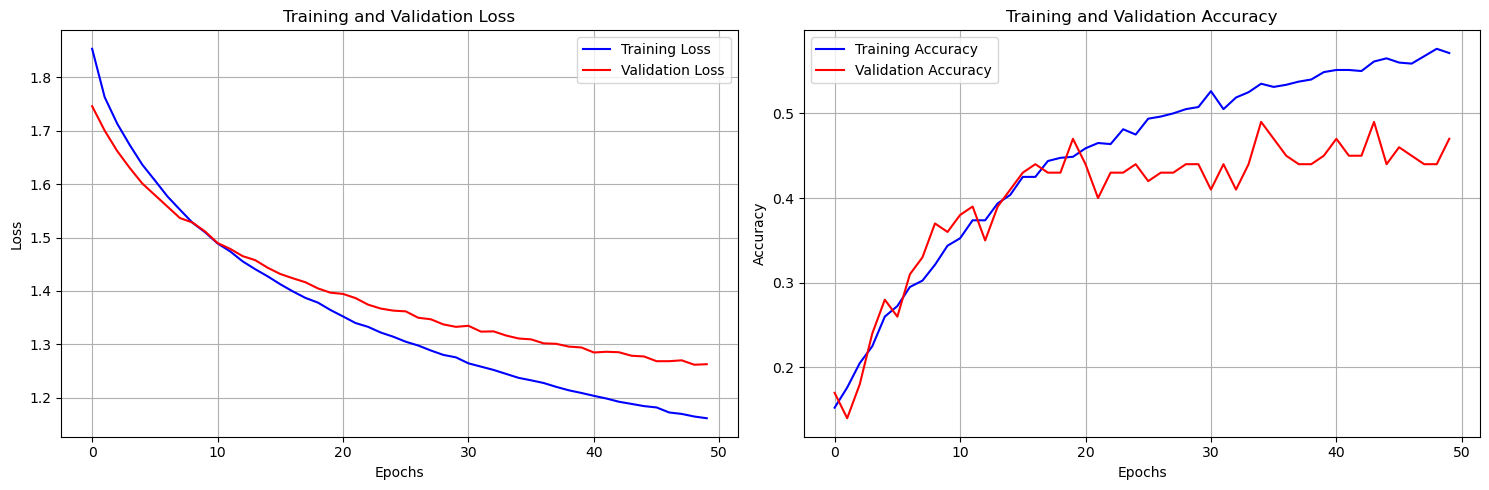

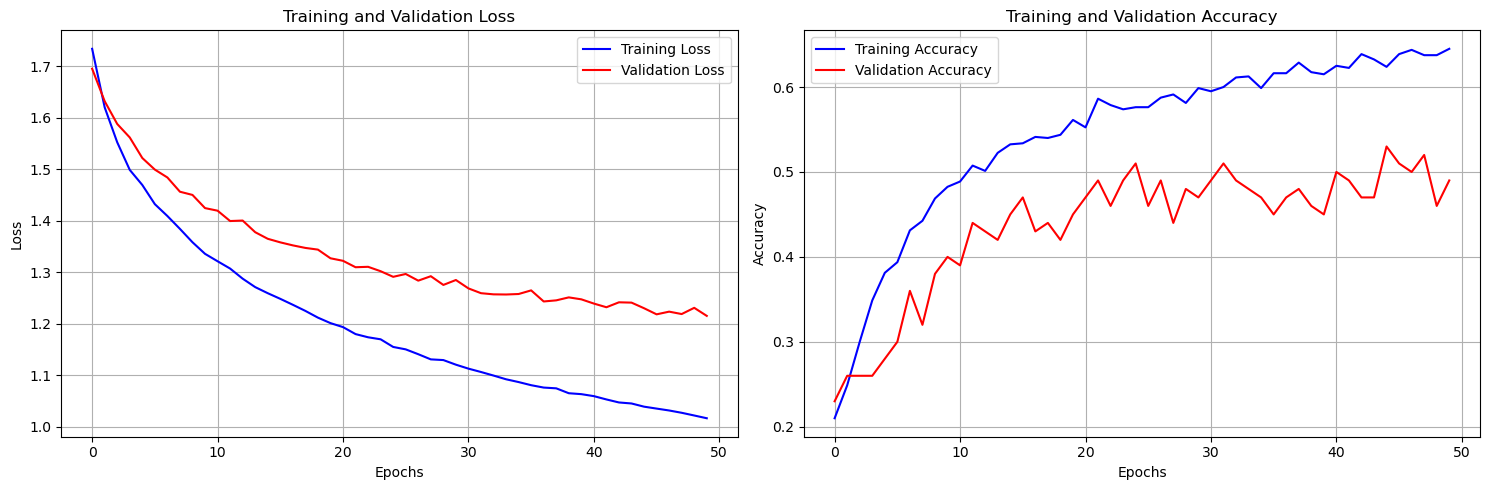

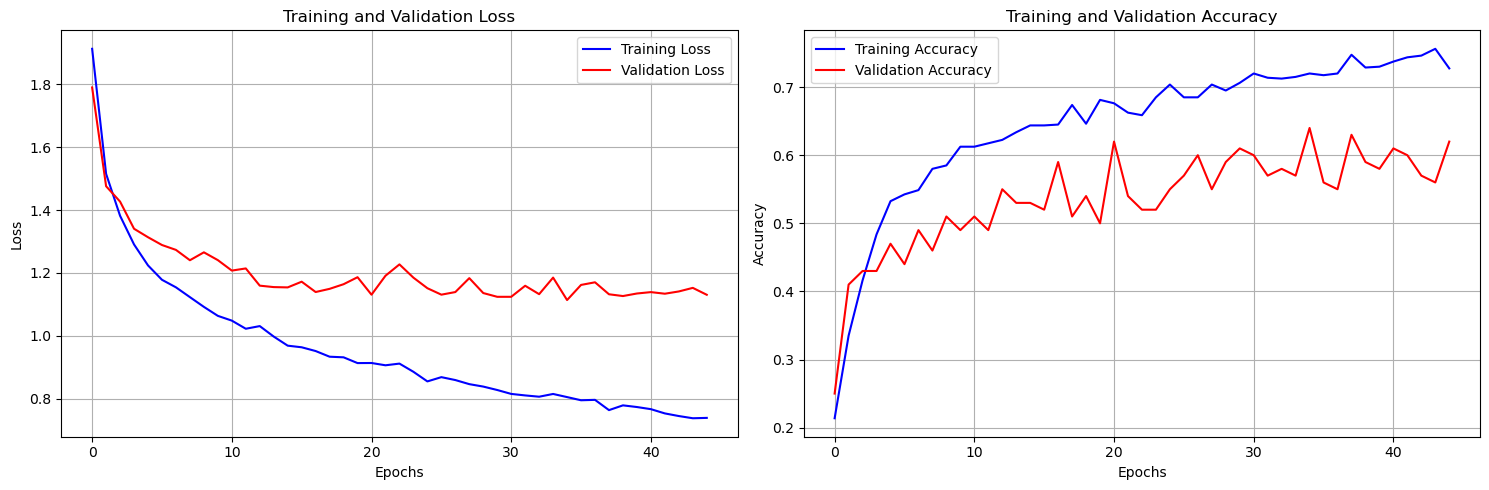

In [27]:
model_1 = transfer_learning(train_set, eval_set, model, (0.001, 0.1, False))
model_2 = transfer_learning(train_set, eval_set, model, (0.001, 0.5, False))
model_3 = transfer_learning(train_set, eval_set, model, (0.001, 0.9, False))

# Plotting the results
plot_errors(model_1)
plot_errors(model_2)
plot_errors(model_3)

### Report
With `momentum = 0.1`, both training and validation accuracy improve steadily. The training and validation loss converge but then appear to separate slightly, indicating there might be some overfitting.

At `momentum = 0.5`, the model learns faster, achieving higher training and validation accuracy earlier, but a growing gap between them indicates some overfitting.

With `momentum = 0.9`, training accelerates further and training accuracy peaks quickly, but validation accuracy plateaus while becoming more erratic, indicating significant overfitting and instability.

Overall, higher momentum increases learning speed but also the risk of overshooting and generalization issues. Based on these plots, the best momentum value is 0.1, increasing the learning rate significantly (compared to previous models with momentum of 0) with some limited signs of overfitting.

## Task 13
Now using “accelerated transfer learning”, repeat the training process (k-fold validation is optional this time). You should prepare your training, validation and test sets based on {(F(x1).t1), (F(x2),t2),...,(F(xm),tm)}, and re-do Task 12. 


In [31]:
def extract_features(model, images):
    """
    Extract features from the base model for accelerated transfer learning.
    
    Parameters:
    -----------
    model : keras.Model
        The base model used for feature extraction
    images : numpy.ndarray
        Input images
        
    Returns:
    --------
    numpy.ndarray
        Extracted features
    """
    # Create a feature extraction model that outputs the layer before the classification layer
    feature_extractor = keras.models.Model(
        inputs=model.input,
        outputs=model.output
    )
    
    # Extract features in batches to prevent memory issues
    batch_size = 32
    n_samples = len(images)
    n_batches = (n_samples + batch_size - 1) // batch_size
    
    features = []
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_samples)
        batch = images[start_idx:end_idx]
        batch_features = feature_extractor.predict(batch, verbose=0)
        features.append(batch_features)
    
    return np.vstack(features)

def accelerated_learning(train_set, eval_set, model, parameters):
    """
    Implement and perform accelerated transfer learning.
    
    Instead of passing images through the base model during each training iteration,
    we pre-compute the features once and then train only the classifier layers.

    Parameters:
    -----------
    train_set : tuple
        Tuple of (images, labels) for training
    eval_set : tuple
        Tuple of (images, labels) for validation
    model : keras.Model
        Base model for feature extraction
    parameters : tuple
        Tuple of (learning_rate, momentum, nesterov)
        
    Returns:
    --------
    keras.Model
        Trained classifier model
    """
    # Unpack parameters
    learning_rate, momentum, nesterov = parameters
    
    # Unpack datasets
    x_train, y_train = train_set
    x_eval, y_eval = eval_set
    
    # Pre-compute features for training and validation sets
    print("Extracting features from training set...")
    train_features = extract_features(model, x_train)
    print("Extracting features from validation set...")
    eval_features = extract_features(model, x_eval)
    
    # Get number of classes
    num_classes = len(np.unique(y_train))
    
    # Get feature dimensions
    feature_dim = train_features.shape[1:]
    
    # Create a new classifier model that takes features as input
    feature_input = keras.layers.Input(shape=feature_dim)
    x = keras.layers.GlobalAveragePooling2D()(feature_input)
    predictions = keras.layers.Dense(num_classes, activation='softmax')(x)
    classifier_model = keras.models.Model(inputs=feature_input, outputs=predictions)
    
    # Compile the model
    optimizer = keras.optimizers.SGD(learning_rate, momentum, nesterov)
    classifier_model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Define callbacks
    checkpoint = keras.callbacks.ModelCheckpoint(
        "best_accelerated_model.keras",
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    # Train the model on pre-computed features
    history = classifier_model.fit(
        train_features, y_train,
        validation_data=(eval_features, y_eval),
        epochs=50,
        batch_size=32,
        callbacks=[checkpoint, early_stopping],
        verbose=1
    )
    
    # Create a full model that combines feature extraction and classification
    full_model = keras.models.Model(
        inputs=model.input,
        outputs=classifier_model(model.output)
    )

    full_model.history = history
    
    return full_model


Plot and comment on the results and differences against the standard implementation of transfer learning. 

Extracting features from training set...
Extracting features from validation set...
Epoch 1/50
 1/25 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.1562 - loss: 2.1882
Epoch 1: val_accuracy improved from -inf to 0.32000, saving model to best_accelerated_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1966 - loss: 1.9775 - val_accuracy: 0.3200 - val_loss: 1.6157
Epoch 2/50
 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4375 - loss: 1.3374
Epoch 2: val_accuracy improved from 0.32000 to 0.36000, saving model to best_accelerated_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3366 - loss: 1.6020 - val_accuracy: 0.3600 - val_loss: 1.5363
Epoch 3/50
 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4062 - loss: 1.3110
Epoch 3: val_accuracy improved from 0.36000 to 0.37000, saving model to best_accelerated_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4043 - loss: 1.4397 - val_accuracy: 0.3700 - val_loss: 1.4463
Epoch 4/50
 1/

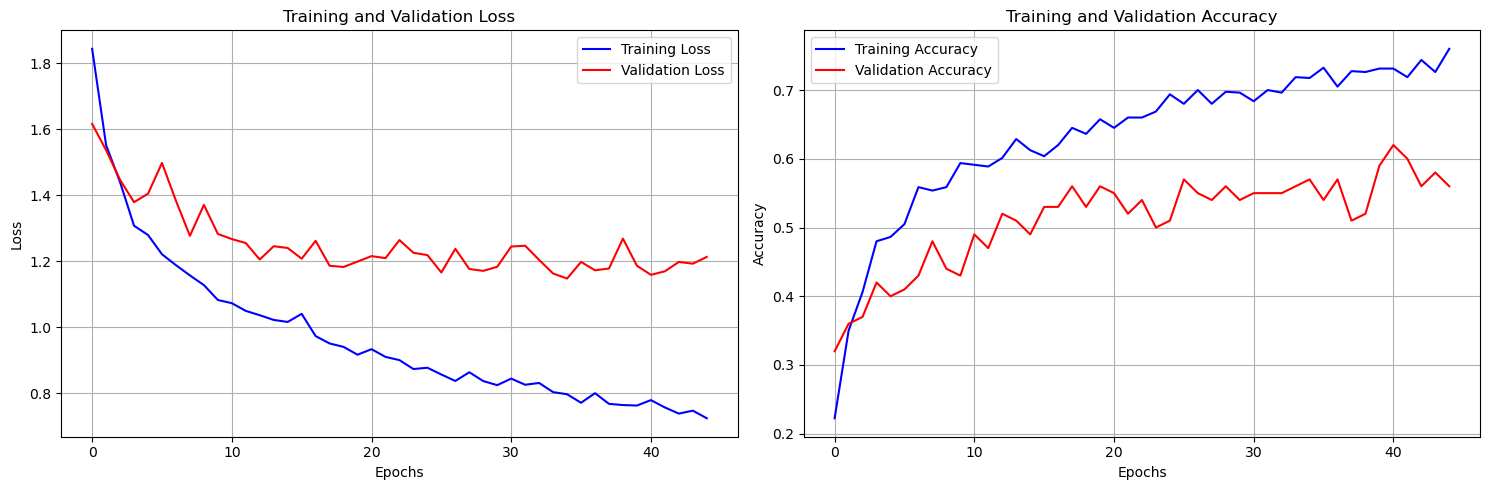

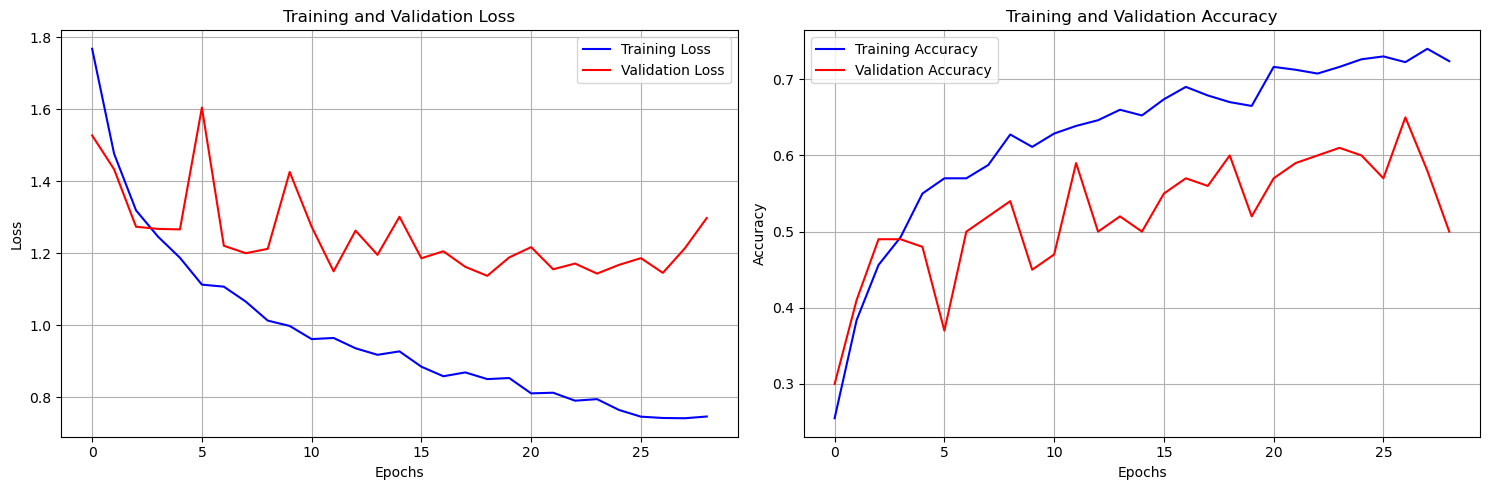

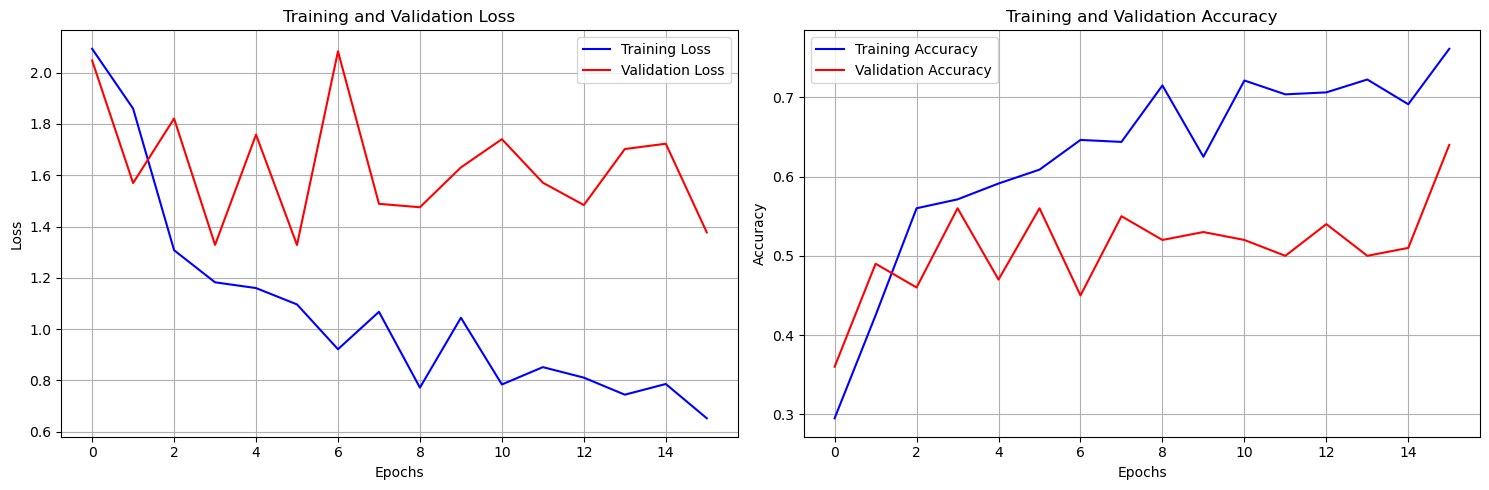

In [32]:
# Change this to have best learning rate and different non-zero momentum ALSO CHANGE NAMES 

model_4 = accelerated_learning(train_set, eval_set, model, (0.01, 0.1, False))
model_5 = accelerated_learning(train_set, eval_set, model, (0.01, 0.5, False))
model_6 = accelerated_learning(train_set, eval_set, model, (0.01, 0.9, False))

# Plotting the results
plot_errors(model_4)
plot_errors(model_5)
plot_errors(model_6)

### Your Comments:

Across all momentum rates (0.1, 0.5, and 0.9), the model is more erratic and training and validation loss do not converge stably. This indicates that while accelerated transfer learning is significantly less computationally intensive and quicker, it does not perform as well as standard transfer learning, particulary on this small dataset. There are significant signs of overfitting in the training and validation accuracy plots with a large gap between training accuracy and validation accuracy.

## Task 14
Use the results of all experiments to make suggestions for future work and recommendations for parameter values to anyone else who may be interested in a similar implementation of transfer learning.

### Your answer:
The suggested parameter values are: `learning_rate = 0.01`; `momentum = 0.1`. It is recommended to use standard transfer learning instead of accelerated transfer learning, as accelerated transfer learning produces less stable models with more signs of overfitting. The findings of these experiments are limited by the small dataset used; the ideal parameter values and choice between standard and accelerated transfer learning may be different for a larger dataset.